In [2]:
from torch.nn import BCEWithLogitsLoss
import torch
import numpy as np
from func.network import VoxResNet, CellSegNet_basic_lite
import matplotlib.pyplot as plt

In [5]:
load_path = 'output/model_HMS_edge_gated.pkl'
#load_path = 'output/model_HMS_delete_fake_cells.pkl'

# init model
model=CellSegNet_basic_lite(input_channel=1, n_classes=1, output_func = "softmax")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)


<All keys matched successfully>

In [6]:
test_img = np.load("data/CellSeg_dataset/HMS_processed/raw/70.npy")

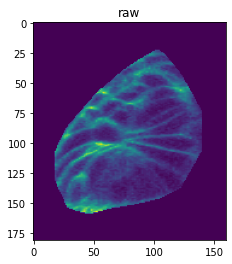

In [7]:
plt.figure()
plt.title("raw")
plt.imshow(test_img[:,150,:])

In [8]:
test_img_cropped = test_img[60:124, 100:164, 40:104]


In [9]:
raw_img_crop=torch.from_numpy(test_img_cropped).float().to(device)
raw_img_crop = torch.unsqueeze(raw_img_crop, 0)
raw_img_crop = torch.unsqueeze(raw_img_crop, 0)
print(raw_img_crop.shape)
output_model = model(raw_img_crop)

torch.Size([1, 1, 64, 64, 64])


In [10]:
output_model = output_model.detach().numpy()

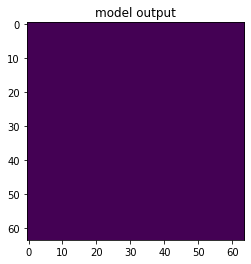

In [11]:
plt.figure()
plt.title("model output")
plt.imshow(output_model[0,0,:,50,:])

In [12]:
np.unique(output_model)

array([1.], dtype=float32)

Investigate loss function



In [13]:
from func.loss_func import dice_loss_org

In [37]:
mock_target = torch.tensor([[[1,0,0,0,0],
                             [0,1,0,0,0],
                             [0,0,1,0,0]],
                            [[0,0,0,0,0],
                             [0,0,0,0,0],
                             [0,0,0,0,0]],
                            [[0,0,0,0,0],
                             [0,0,0,0,0],
                             [0,0,0,0,0]]])

mock_output = torch.tensor([[[1,0,0,0,0],
                             [0,1,0,0,0],
                             [0,0,0,0,0]],
                            [[0,0,0,0,0],
                             [0,0,0,0,0],
                             [0,0,0,0,0]],
                            [[0,0,0,0,0],
                             [0,0,0,0,0],
                             [0,0,0,0,0]]])

mock_target = torch.unsqueeze(mock_target,dim=0)
mock_target = torch.unsqueeze(mock_target,dim=0)

mock_output = torch.unsqueeze(mock_output,dim=0)
mock_output = torch.unsqueeze(mock_output,dim=0)

In [38]:
dice_loss_org(mock_target, mock_output)

tensor(0.1667)

In [36]:
mock_target.shape

torch.Size([1, 1, 3, 3, 5])